## Log

Here're all the masks we got: [Hemishpere mask], [CMASS north mask], [Planck plane mask], [Planck point source mask].

    [DONE] Make a Nside=1024 and 2048 CMASS mask from the .ply file. This step could take more time. So I just use [ud_grade](http://healpy.readthedocs.io/en/latest/generated/healpy.pixelfunc.ud_grade.html) for now.

    [DONE] Convert the Nside=2048 Planck frequency mask.

    [Pending] Apply the window functions. (mask, pixel, beam) Discard beam window function for now.
    

I got the true? signal by cross CMASS(without cmass mask) and CIB 545(all mask). Strange!

I tried a more aggressive mask (COVERAGE=20) and the results turned out to be reseanable. 


In [1]:
%matplotlib inline
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_3j
import sys
from tqdm import tqdm_notebook
import multiprocessing as mp
from functools import partial

FGAL =  '/Users/jh/Desktop/data/LRG_catalog/zGT070/selected_'
CMASSNORTH = '/Users/jh/Desktop/data/SDSS/galaxy_DR12v5_CMASS_North.fits'
FMAP ={ 857:'/Users/jh/Desktop/data/Planck/HFI_SkyMap_857_2048_R2.02_full.fits',
       545:'/Users/jh/Desktop/data/Planck/HFI_SkyMap_545_2048_R2.02_full.fits'}
PCFIELD = {353:3, 545:4, 857:5}
FMAPMASKPLANE = '/Users/jh/Desktop/data/Planck/HFI_Mask_GalPlane-apo2_2048_R2.00.fits'
GALMAPMASKTHRESHOLD = 0.5
FMAPMASKPS = '/Users/jh/Desktop/data/Planck/HFI_Mask_PointSrc_2048_R2.00.fits'
FMAPPCCS = '/Users/jh/Desktop/data/Planck/COM_PCCS_857-SN-threshold_R2.01.fits'
PLANEMASKFIELD = {20:0, 40:1, 60:2, 70:3, 80:4}
u_coeff = 5.155
g_coeff = 3.793
r_coeff = 2.751
LMAX = 1024
NSIDE = 1024
NSIDE_PLANCK = 2048
PLANEMASKCOVERAGE = 20

In [2]:
def cl_read(fn):
    f = open(fn)
    con = f.readlines()
    ell = []
    cl  = []
    for line in con:
        line = line.split()
        ell.append( int(line[0]) )
        cl.append( float(line[1]))
    return ell, cl

def cl_binned(l, cl, binSize): 
    nbins = len(l)/binSize
    l_bin = []
    cl_bin = []
    for ib in xrange(nbins):
        l_mid = ib*binSize + binSize/2 + l[0]
        elLs = range(ib*binSize+l[0],(ib+1)*binSize+l[0])
        modes = sum( 2*el +1 for el in elLs)
        cl_mid = sum( [ cl[el-l[0]] * (2*el +1.0) for el in elLs ] )/ modes
        l_bin.append(l_mid)
        cl_bin.append( cl_mid   )

    return l_bin, cl_bin

def cl_save(l, cl, fn):
    fw = open(fn, 'w')
    for i in xrange(len(cl)):
        fw.write("%i      %.10e \n"%(l[i], cl[i]))
    fw.flush()
    fw.close()
    return

def cl_plot(cl, binSize=1, lmin=0, style='bo', alpha=0.7, c='b', label=None):
    ell = np.arange(len(cl))
    ell_bin, cl_bin = cl_binned(ell[lmin:], cl[lmin:], binSize)
    fig, = plt.plot(ell_bin, cl_bin, style, alpha=alpha, c=c, label=label)
    return fig
    
def cross_alm(almIn1, almIn2, binSize=128, lmin=100, doPlot=True, title="", xlabel='$l$',\
              ylabel='$C_l$ (Jy / sr)', style='bs', c='b', label=None, w=1):
    """ if the inputs are file names, read the .alm files and do the cross correlation.
        if the inputs are ndarray of alm data, do the cross correlation directly.
    """
    
    if type(almIn1).__name__ == 'str' and type(almIn2).__name__ == 'str':
        alm1 = hp.read_alm(almIn1)
        alm2 = hp.read_alm(almIn2)
        
    elif type(almIn1).__name__ == 'ndarray' and type(almIn2).__name__ == 'ndarray':
        alm1 = almIn1
        alm2 = almIn2
        
    else:
        print "Check you input data format. Only filename or alm sequences are accepted."
    
    cl_cross = hp.alm2cl(alm1, alm2)*w
    
    if doPlot:
        fig = cl_plot(cl_cross, binSize=binSize, lmin=lmin, style=style, c=c, label=label)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        return cl_cross, fig
    else:
        return cl_cross
    
def radec2thetaphi(ra, dec):
    theta = (-1)*dec*np.pi/180. + np.pi/2.
    phi = ra*np.pi/180. 
    return theta, phi

def ug2UB(data):
    """
    The transformation equation from u-g to U-B used here is
    U-B = (0.79 ± 0.02)*(u-g) - (0.93 ± 0.02)
    [Jordi et al. (2006)]
    """

    UB = - 0.82 \
         + 0.52 * (  (data['modelmag'][:][:,0] - data['SFD_dust'][:]*u_coeff)
                   - (data['modelmag'][:][:,1] - data['SFD_dust'][:]*g_coeff))\
         + 0.53 * (  (data['modelmag'][:][:,1] - data['SFD_dust'][:]*g_coeff)
                   - (data['modelmag'][:][:,2] - data['SFD_dust'][:]*r_coeff))
    return UB


fac = np.ones(160)
for i in xrange(1,160):
    fac[i] = fac[i-1]*float(i)
    
def wig3j(a,b,c):
    """
    This function returns ( a  b  c ) 
                          ( 0  0  0 )
    Note that the factorial overflows for large integers.
    Therefore, I adopted Stirling's formula to approx it.
    However, this approx is bad (roughly 10%-50% error). So
    I use wigner_3j function from sympy instead.
    """
    
    if (a+b+c)%2:
        return 0

    elif c>=np.abs(a-b) and c<=a+b:
        p = (a+b+c)/2
        if a+b+c+1 > 160:
            return (-1)**p * np.e**(-1) * ( p*(p-a)*(p-b)*(p-c) )**(-0.25)
        else:
            return (-1)**p * np.sqrt(fac[2*p-2*a] * fac[2*p-2*b] * fac[2*p-2*c] / fac[2*p+1] ) \
               *fac[p] / (  fac[p-a]*fac[p-b]*fac[p-c]   )
    else:
        return 0
    



# Combined Mask

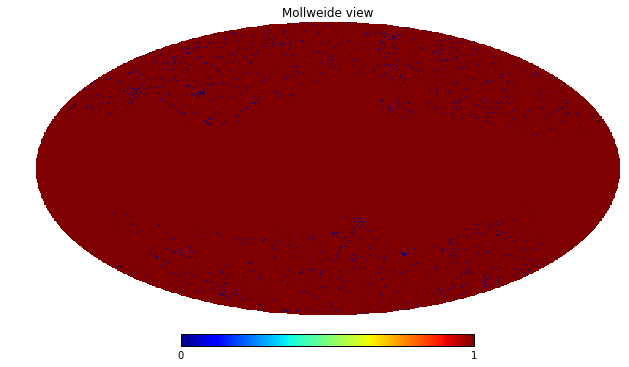

In [3]:
## PCCS ##
NSIDE_PCCS = 512
theta = np.array([])
phi   = np.array([])

fits = fitsio.FITS('/Users/jh/Desktop/data/Planck/COM_PCCS_857_R2.01.fits')
theta = np.append(theta, fits[1]['DEC'][:])
phi   = np.append(phi,   fits[1]['RA'][:])
fits.close()

##===  (ra, dec) -> (theta, phi)
theta = (-1)*theta*np.pi/180. + np.pi/2.
phi = phi*np.pi/180. 

##===  Celestial coordinate -> galactic coordinate
rotation = [0.0, 0.0] ## (phi, theta) in deg.
r_C2G = hp.Rotator(rot=rotation, coord=['C', 'G'])
theta, phi = r_C2G(theta, phi)

#==============  galaxies --> pixel =================
PCCSMap = np.zeros(hp.nside2npix(NSIDE_PCCS))
PCCSPix = hp.ang2pix(NSIDE_PCCS, theta, phi)

for pix in PCCSPix:
    for nei in hp.get_all_neighbours(NSIDE_PCCS, pix):
        PCCSMap[nei]=1

PCCSMap = np.logical_not(PCCSMap)        
hp.mollview(PCCSMap)
plt.show()


[DONE] south mask
[DONE] CMASS mask
[DONE] Planck mask


/Users/jh/Library/Python/2.7/lib/python/site-packages/healpy/fitsfunc.py:335: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


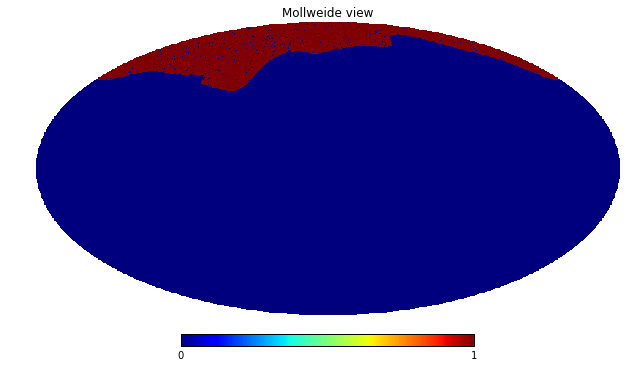

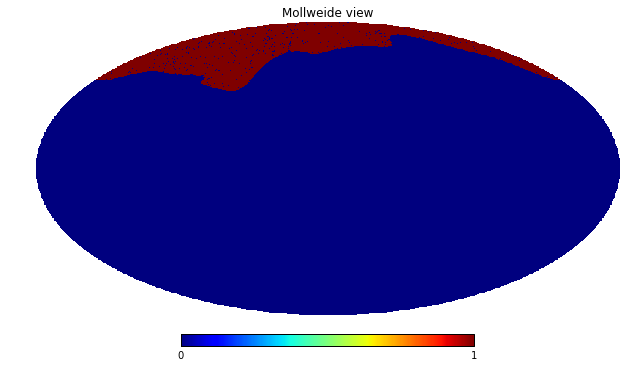

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


In [4]:
#####################################
##            Constants            ##
#####################################
MAPFREQ = 857
PHI_ROT = 0
##============= south mask  ====================
maskHemi_2048 =  np.arange(hp.nside2npix(NSIDE_PLANCK))
npixs = len(maskHemi_2048)
for i in xrange(npixs):
    if (i< npixs/2):
        maskHemi_2048[i] = True
    else:
        maskHemi_2048[i] = False

maskHemi_1024 =  np.arange(hp.nside2npix(NSIDE))
npixs = len(maskHemi_1024)
for i in xrange(npixs):
    if (i< npixs/2):
        maskHemi_1024[i] = True
    else:
        maskHemi_1024[i] = False
print "[DONE] south mask"

##============== DR12 CMASS North mask ==============
if PHI_ROT == 0:
    GALMAPMASK = '/Users/jh/Desktop/data/SDSS/mask_DR12v1_CMASS_North_1024_galactic_x4.fits'
else:
    GALMAPMASK = "/Users/jh/Desktop/data/SDSS/mask_DR12v1_CMASS_North_1024_galactic_x4_rot%i.fits"%(PHI_ROT)
galmapmask_1024 = hp.read_map(GALMAPMASK, verbose=False)
# galmapmask_1024 = galmapmask_1024 > GALMAPMASKTHRESHOLD
galmapmask_2048 = hp.ud_grade(galmapmask_1024, NSIDE_PLANCK)
galmapmask_1024 = hp.ud_grade(galmapmask_1024, NSIDE)



print "[DONE] CMASS mask"

##====== mask out plane and PS ========
# maskPS_2048 = hp.read_map(FMAPMASKPS, field=PCFIELD[MAPFREQ], verbose=False) ##field=5 for F857
# maskPS_1024 = hp.ud_grade(maskPS_2048, nside_out=NSIDE) > 0.2
# maskPS_2048 = maskPS_2048 > 0.2

maskPlane_2048 = hp.read_map(FMAPMASKPLANE, field=PLANEMASKFIELD[PLANEMASKCOVERAGE], verbose=False)
maskPlane_1024 = hp.ud_grade(maskPlane_2048, nside_out=NSIDE) >0.75
maskPlane_2048 = maskPlane_2048 > 0.75

maskPCCS_2048 = hp.ud_grade(PCCSMap, NSIDE_PLANCK)
maskPCCS_1024 = hp.ud_grade(PCCSMap, NSIDE)
print "[DONE] Planck mask"



mask1024 = np.logical_and( np.logical_and(maskHemi_1024, galmapmask_1024), np.logical_and(maskPCCS_1024, maskPlane_1024))


mask2048 = np.logical_and( np.logical_and(maskHemi_2048, galmapmask_2048), np.logical_and(maskPCCS_2048, maskPlane_2048))
# mask2048 = np.logical_and( np.logical_and(maskHemi_2048, galmapmask_2048), maskPlane_2048)


hp.mollview(mask1024)
hp.mollview(mask2048)
plt.show()
##======== compute the power ============
maskAlm1024 = hp.map2alm(mask1024, lmax=LMAX, pol=False)
maskCl1024  = hp.alm2cl(maskAlm1024)[:LMAX+1]

maskAlm2048 = hp.map2alm(mask2048, lmax=LMAX, pol=False)
maskCl2048  = hp.alm2cl(maskAlm2048)[:LMAX+1]


winPix1024 = hp.pixwin(NSIDE)
winPix2048 = hp.pixwin(NSIDE_PLANCK)

hp.write_alm("res/mask_%i_cov%i_N%i.alm"%(MAPFREQ, PLANEMASKCOVERAGE, NSIDE), maskAlm1024)
hp.write_alm("res/mask_%i_cov%i_N%i.alm"%(MAPFREQ, PLANEMASKCOVERAGE, NSIDE_PLANCK), maskAlm2048)


In [ ]:
"""The Coupling Matrix"""

def Mij(i,j):
    sm = 0.0
    for k in xrange(np.abs(i-j), min(i+j+1, LMAX+1)):
        sm += (2*k+1)* maskCl2048[k]* float(wigner_3j(i,j,k, 0, 0, 0))**2
    return (2*j+1)*sm/(4*np.pi)


print mp.cpu_count()
pool = mp.Pool(processes=mp.cpu_count())
transM = np.zeros((LMAX+1, LMAX+1))
for i in tqdm_notebook(range(LMAX+1), desc="i iteration"):
    transM[i,:] = pool.map(partial(Mij, i), np.arange(LMAX+1))

        
transGG = transM*winPix1024**2
transTT = transM*winPix2048**2
transGT = transM*winPix1024*winPix2048

4


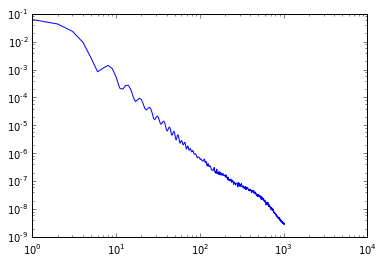

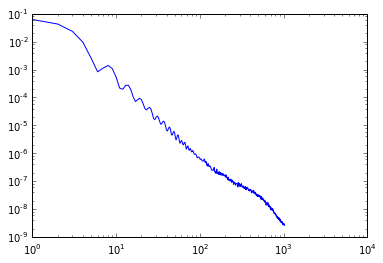

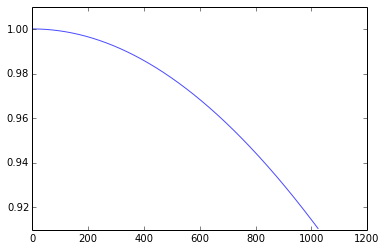

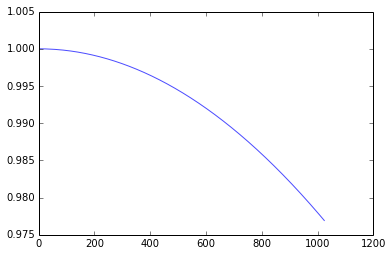

In [7]:
"""Plot the window functions"""
plt.loglog(range(LMAX+1), maskCl1024)
plt.show()
plt.loglog(range(LMAX+1), maskCl2048)
plt.show()

cl_plot(np.power(winPix1024, 2)[:LMAX+1], style='-')
plt.show()

cl_plot(np.power(winPix2048, 2)[:LMAX+1], style='-')
plt.show()

# LRG Map

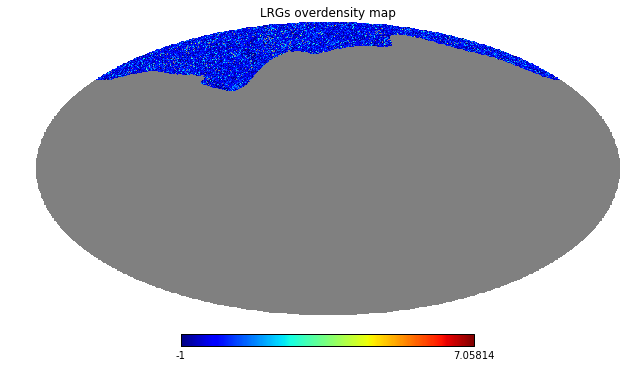

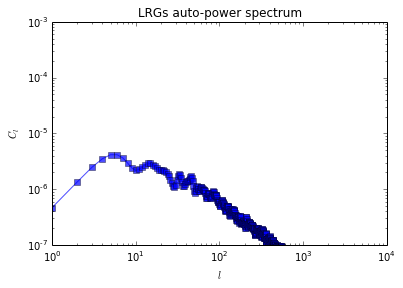

In [73]:
#####################################
##            Constants            ##
#####################################
PHI_ROT = 0
ZGT = '070'

#####################################
##           Galaxies              ##
#####################################
theta = np.array([])
phi   = np.array([])

for i in xrange(545): ## 545 fits files in total
    fits = fitsio.FITS(FGAL+str(i).zfill(3)+'.fits')
    theta = np.append(theta, fits[1]['dec'][:])
    phi   = np.append(phi,   fits[1]['ra'][:])
    fits.close()

##===  (ra, dec) -> (theta, phi)
theta = (-1)*theta*np.pi/180. + np.pi/2.
phi = phi*np.pi/180. 

##===  Celestial coordinate -> galactic coordinate
rotation = [PHI_ROT, 0.0] ## (phi, theta) in deg.
r_C2G = hp.Rotator(rot=rotation, coord=['C', 'G'])
theta, phi = r_C2G(theta, phi)

#==============  galaxies --> pixel =================
galMap = np.zeros(hp.nside2npix(NSIDE))
galPix = hp.ang2pix(NSIDE, theta, phi)

for pix in galPix:
    galMap[pix] += 1  ## count map



##============== apply all the masks ===============
galMapMasked = hp.ma(galMap)
galMapMasked.mask = np.logical_not(mask1024)
        

##============ count --> overdensity ==================
galMap_Ngal = 0
galMap_Npix = 0  ## keep track of the number of pixels covered
for i in xrange(len(galMapMasked)):
    if isinstance(galMapMasked[i], float):
        galMap_Ngal+=galMapMasked[i]
        galMap_Npix+=1
        
countMean = float(galMap_Ngal)/galMap_Npix

for i in xrange(len(galMapMasked)):
    if isinstance(galMapMasked[i], float):
        galMapMasked[i] = (galMapMasked[i] - countMean)/countMean

hp.mollview(galMapMasked, title='LRGs overdensity map')
plt.show()


#######################################
###   galaxy auto-power spectrum    ###
#######################################
galAlm = hp.map2alm(galMapMasked, lmax=LMAX, pol=False)
galCl  = hp.alm2cl(galAlm)
if PHI_ROT==0:
    hp.write_alm("res/zgt%s_north_N%i.alm"%(ZGT, NSIDE), galAlm)
else:
    hp.write_alm("res/zgt%s_north_N%i_rot%i.alm"%(ZGT, NSIDE, PHI_ROT), galAlm)

cl_plot(galCl, style='s-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$l$')
plt.ylabel('$C_l$')
plt.ylim([10**-7, 10**-3])
plt.title('LRGs auto-power spectrum')
plt.show()

galCl_full = np.linalg.solve(transGT, galCl)
cl_plot(galCl_full, style='s-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$l$')
plt.ylabel('$C_l$')
plt.ylim([10**-7, 10**-3])
plt.show()

## CMASS

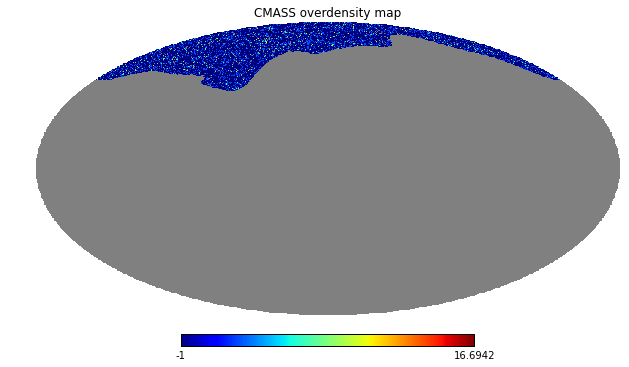

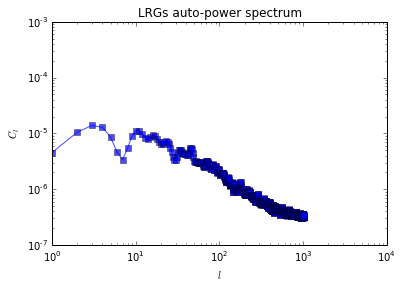

In [74]:
PHI_ROT = 0

#####################################
##           Galaxies              ##
#####################################
theta = np.array([])
phi   = np.array([])

fits = fitsio.FITS(CMASSNORTH)
theta = np.append(theta, fits[1]['DEC'][:])
phi   = np.append(phi,   fits[1]['RA'][:])
fits.close()

##===  (ra, dec) -> (theta, phi)
theta = (-1)*theta*np.pi/180. + np.pi/2.
phi = phi*np.pi/180. 

##===  Celestial coordinate -> galactic coordinate
rotation = [PHI_ROT, 0.0] ## (phi, theta) in deg.
r_C2G = hp.Rotator(rot=rotation, coord=['C', 'G'])
theta, phi = r_C2G(theta, phi)

#==============  galaxies --> pixel =================
cmassMap = np.zeros(hp.nside2npix(NSIDE))
cmassPix = hp.ang2pix(NSIDE, theta, phi)

for pix in cmassPix:
    cmassMap[pix] += 1  ## count map



##============== apply all the masks ===============
cmassMapMasked = hp.ma(cmassMap)
cmassMapMasked.mask = np.logical_not(mask1024)
        

##============ count --> overdensity ==================
cmassMap_Ngal = 0
cmassMap_Npix = 0  ## keep track of the number of pixels covered
for i in xrange(len(cmassMapMasked)):
    if isinstance(cmassMapMasked[i], float):
        cmassMap_Ngal+=cmassMapMasked[i]
        cmassMap_Npix+=1
        
countMean = float(cmassMap_Ngal)/cmassMap_Npix

for i in xrange(len(cmassMapMasked)):
    if isinstance(cmassMapMasked[i], float):
        cmassMapMasked[i] = (cmassMapMasked[i] - countMean)/countMean

hp.mollview(cmassMapMasked, title='CMASS overdensity map')
plt.show()


#######################################
###   galaxy auto-power spectrum    ###
#######################################
cmassAlm = hp.map2alm(cmassMapMasked, lmax=LMAX, pol=False)
cmassCl  = hp.alm2cl(cmassAlm)
if PHI_ROT==0:
    hp.write_alm("res/CMASS_north_N%i.alm"%(NSIDE), cmassAlm)
else:
    hp.write_alm("res/CMASS_north_N%i_rot%i.alm"%(NSIDE, PHI_ROT), cmassAlm)

cl_plot(cmassCl, style='s-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$l$')
plt.ylabel('$C_l$')
plt.ylim([10**-7, 10**-3])
plt.title('LRGs auto-power spectrum')
plt.show()

# galCl_full = np.linalg.solve(transGG, galCl)
# cl_plot(galCl_full, style='s-')
# plt.show()

# Planck Map

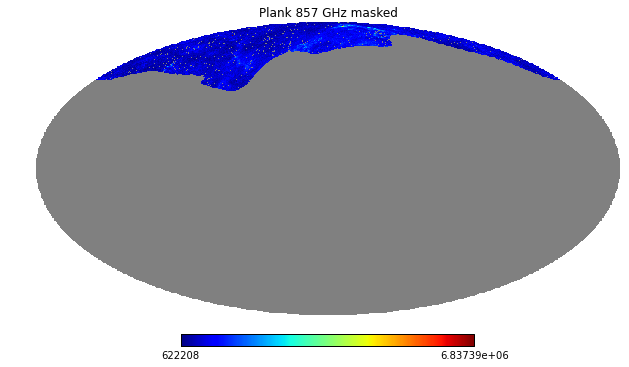

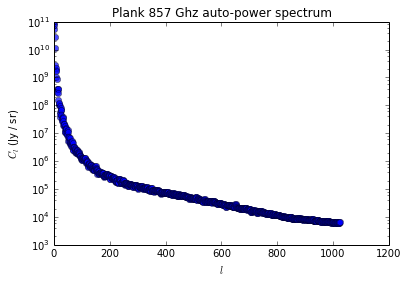

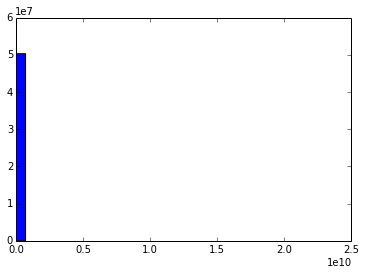

In [75]:
%matplotlib inline
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

#####################################
##            Constants            ##
#####################################
PLANEMASKCOVERAGE = 40
MAPFREQ = 857

######################################
##           Planck Map             ##
######################################

planckmap = hp.read_map(FMAP[MAPFREQ], verbose=False)*10**6

planckmapMasked = hp.ma(planckmap)
planckmapMasked.mask = np.logical_not(mask2048)

hp.mollview(planckmapMasked,title="Plank %i GHz masked"%(MAPFREQ))
plt.show()


#########################################
###     CIB auto-power spectrum      ####
#########################################
planckAlm = hp.map2alm(planckmapMasked, lmax=LMAX, pol=False)
planckCl  = hp.alm2cl(planckAlm)
hp.write_alm("res/planck%i_cov%i_north_combinedMask.alm"%(MAPFREQ, PLANEMASKCOVERAGE), planckAlm)
cl_plot(planckCl)
plt.xlabel('$l$')
plt.ylabel('$C_l$ (Jy / sr)')
plt.yscale('log')
plt.title('Plank %i Ghz auto-power spectrum'%(MAPFREQ))
plt.show()

plt.hist(planckmapMasked, bins=30)
plt.show()

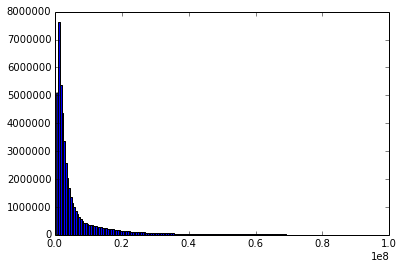

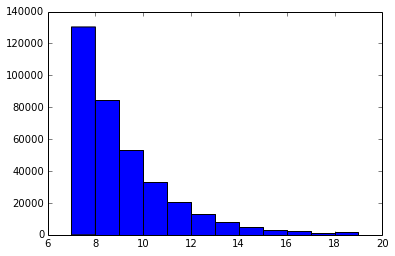

-4.97339414096e-09


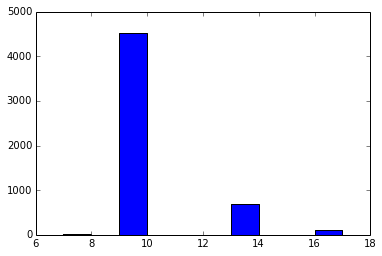

-6.66014710049e-09


In [92]:
plt.hist(planckmapMasked, bins=np.arange(6*10**5, 10**8, 5*10**5))
plt.show()

plt.hist(galMapMasked, bins=np.arange(7,20))
plt.show()
print np.sum(galMapMasked)

plt.hist(cmassMapMasked, bins=np.arange(7,20))
plt.show()
print np.sum(cmassMapMasked)

-5.13655156487e-15 0.655322077514
-6.87864022872e-15 1.9655996356


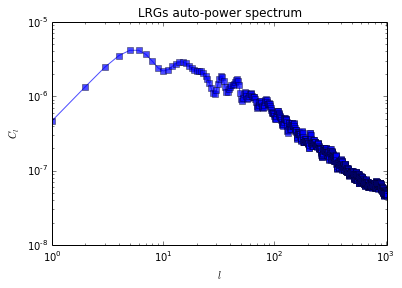

In [93]:
print np.mean(galMapMasked), np.std(galMapMasked)
print np.mean(cmassMapMasked), np.std(cmassMapMasked)


cl_plot(galCl, style='s-')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$l$')
plt.ylabel('$C_l$')
plt.xlim([0, LMAX])
plt.ylim([10**-8, 10**-5])
plt.title('LRGs auto-power spectrum')
plt.show()

# Cross-Correlation

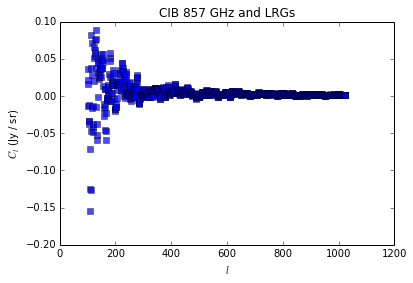

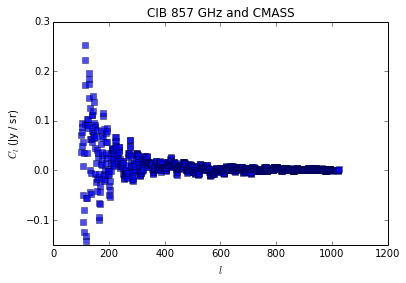

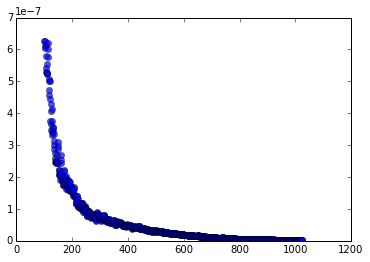

In [77]:
LMIN = 100
BINSIZE = 1

f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
f_palm = "res/planck%i_cov%i_north_combinedMask.alm"%(857, PLANEMASKCOVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE, w=winPix1024[:LMAX+1]*winPix2048[:LMAX+1])
plt.title('CIB %i GHz and LRGs'%(857))
# plt.xscale('log')
plt.show()

f_galm = "res/CMASS_north_N%i.alm"%(NSIDE)
f_palm = "res/planck%i_cov%i_north_combinedMask.alm"%(857, PLANEMASKCOVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE, w=winPix1024[:LMAX+1]*winPix2048[:LMAX+1])
plt.title('CIB %i GHz and CMASS'%(857))
# plt.xscale('log')
plt.show()

cl_plot(maskCl1024, lmin=LMIN, binSize=BINSIZE)
plt.show()


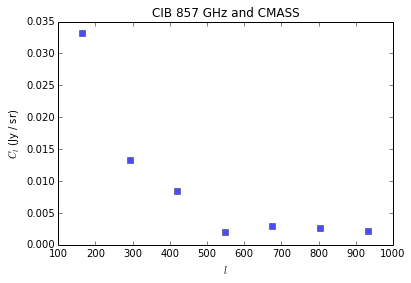

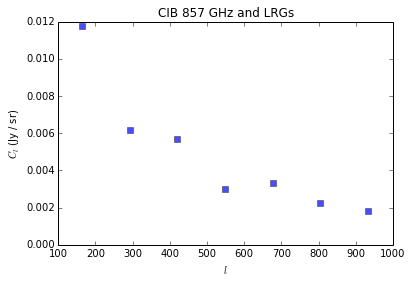

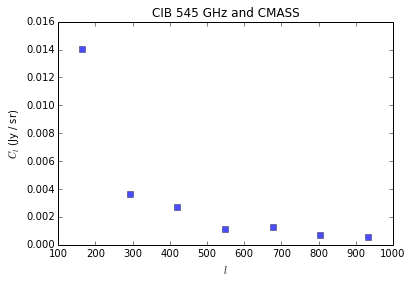

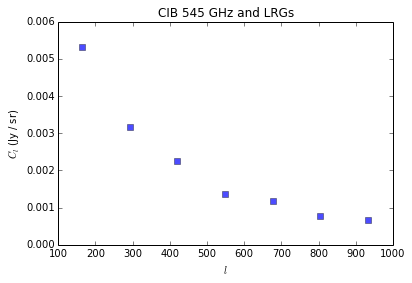

In [78]:
LMIN = 100
BINSIZE = 128
ZGT = '070'


f_galm = "res/CMASS_north_N%i.alm"%(NSIDE)
f_palm = "res/planck%i_cov%i_north_combinedMask.alm"%(857, PLANEMASKCOVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('CIB %i GHz and CMASS'%(857))
plt.show()


f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
f_palm = "res/planck%i_cov%i_north_combinedMask.alm"%(857, PLANEMASKCOVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('CIB %i GHz and LRGs'%(857))
plt.show()

f_galm = "res/CMASS_north_N%i.alm"%(NSIDE)
f_palm = "res/planck%i_cov%i_north_combinedMask.alm"%(545, PLANEMASKCOVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('CIB %i GHz and CMASS'%(545))
plt.show()


f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
f_palm = "res/planck%i_cov%i_north_combinedMask.alm"%(545, PLANEMASKCOVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('CIB %i GHz and LRGs'%(545))
plt.show()

### LRG z>0.7 vs. CIB at 545 GHz

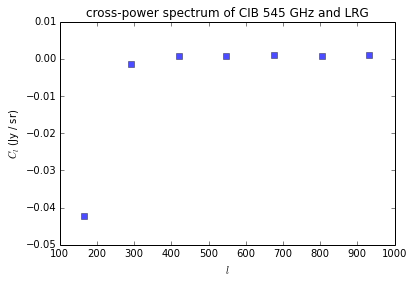

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

MAPFREQ = 545
COVERAGE=40
LMIN = 100
BINSIZE = 128
ZGT = '070'
x = np.linspace(100,1000, 100)
y = x*0.0
####################################
###         LRG vs. 545          ###
####################################
f_galm = "res/zgt%s_north_N%i.alm"%(ZGT, NSIDE)
f_palm = "res/planck%i_cov%i_north_combinedMask.alm"%(MAPFREQ, COVERAGE)
cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
plt.title('cross-power spectrum of CIB %i GHz and LRG'%(MAPFREQ))
# plt.savefig('figure/zgt070_545_N512.eps')
plt.show()

# ## =========== Rotate 90 =============
# f_galm = "res/zgt%s_north_N%i_rot%i.alm"%(ZGT, NSIDE, 90)
# f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
# cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
# plt.title('Rotate $\Delta \phi = 90\degree$')
# plt.plot(x, y, 'k--')
# plt.savefig('figure/zgt070_545_N512_rot90.eps')
# plt.show()

# ## =========== Rotate 180 ===============
# f_galm = "res/zgt%s_north_N%i_rot%i.alm"%(ZGT, NSIDE, 180)
# f_palm = "res/planck%i_cov%i_north.alm"%(MAPFREQ, COVERAGE)
# cross_alm(f_galm, f_palm, lmin=LMIN, binSize=BINSIZE)
# plt.title('Rotate $\Delta \phi = 180\degree$')
# plt.plot(x, y, 'k--')
# plt.savefig('figure/zgt070_545_N512_rot180.eps')
# plt.show()

